<a href="https://colab.research.google.com/github/BLOSSOM1994/CarDivar-/blob/main/evaluate_mask_car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/matterport/Mask_RCNN

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 39.82 MiB/s, done.
Resolving deltas: 100% (562/562), done.


In [2]:
#RUN GPU
%tensorflow_version 1.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 1.x selected.
Found GPU at: /device:GPU:0


In [3]:
import os
os.chdir('Mask_RCNN')

In [4]:
!ls

assets	LICENSE      mrcnn	requirements.txt  setup.cfg
images	MANIFEST.in  README.md	samples		  setup.py


In [5]:
!python3 setup.py install;

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:645: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'ma

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Mask RCNN Evaluation - nissan

*   List item
*   List item



In this notebook I evaluate the Mask-RCNN model used to detect nissans using the model trained Google Colabs.  

**Note: Some of the functions in these cells may need to run on colabs due to the resources required. I have put a warning before these cells.**



Parts of this script were adapted from the [Matterport Balloons Example](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon)  
Some of the plotting function were adapted from [Machine Learning Mastery](https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/)

In [7]:
import mrcnn
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn import visualize
from mrcnn import utils
from mrcnn.model import MaskRCNN, load_image_gt, mold_image, log

import numpy as np
import colorsys
import argparse
import random
import os
import sys
import time
import json
import skimage
import datetime
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

Using TensorFlow backend.


In [11]:
modeldir='/content/drive/MyDrive/Colab Notebooks/Data/'
datadir=modeldir+'Car_test/'

## Set up the config and dataset classes for the training and test datasets
For the fully annotated version see the [training model](./maskRCNN_colab_train.ipynb)

In [9]:
class myMaskRCNNConfig(Config):
    NAME = "MaskRCNN_config"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    NUM_CLASSES = 1+1
    STEPS_PER_EPOCH = 80
    LEARNING_RATE=0.001
    DETECTION_MIN_CONFIDENCE = 0.9
    MAX_GT_INSTANCES=10
    
config = myMaskRCNNConfig()
config.display()

check=[]
class nissanDataset(utils.Dataset):

    def load_dataset(self, dataset_dir):
        self.add_class("nissan", 1, "nissan")
        annotations = json.load(open(os.path.join(modeldir, "nissan_json.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        for a in annotations:
            if a['filename'] in os.listdir(dataset_dir):       
                if type(a['regions']) is dict:
                        polygons = [r['shape_attributes'] for r in a['regions'].values()]
                        #print('\n\n1:\n\n'+polygons)
                else:
                        polygons = [r['shape_attributes'] for r in a['regions']]

                image_path = os.path.join(dataset_dir, a['filename'])
                image = skimage.io.imread(image_path)
                height, width = image.shape[:2]
    
                self.add_image(
                    "nissan",
                    image_id=a['filename'],  # use file name as a unique image id
                    path=image_path,
                    width=width, height=height,
                    polygons=polygons)

    def load_mask(self, image_id):
        # If not a nissan dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "nissan":
            print('not a nissan!')
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        
        class_id=[]
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1
            class_id.append(self.class_names.index('nissan'))

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "nissan":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [12]:
# prepare train set
train_set = nissanDataset()
train_set.load_dataset(datadir+'/train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = nissanDataset()
test_set.load_dataset(datadir+'/test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 20
Test: 3


Let's have a look at an image with multiple masks to check the they have been loaded correctly:

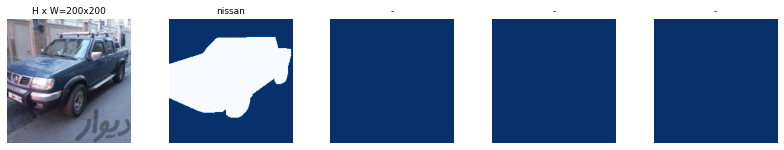

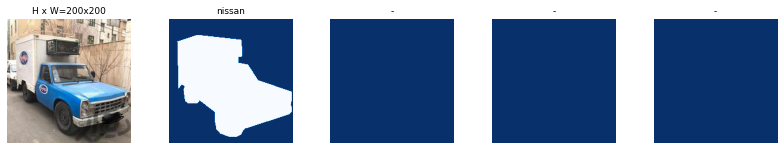

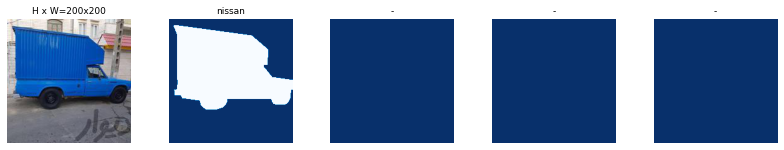

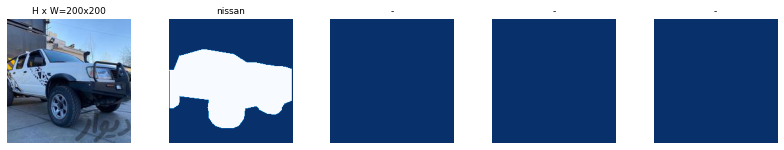

In [18]:
image_id=6
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

image_id=15
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, train_set.class_names)


image_id=2
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

image_id=19
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

## Examine the training set
Have a look at the training data and check that the 'info' and 'polygons' masks are as expected.

In [19]:
print("Image Count: {}".format(len(train_set.image_ids)))
print("Class Count: {}".format(train_set.num_classes))
for i, info in enumerate(train_set.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 20
Class Count: 2
  0. BG                                                
  1. nissan                                            


## Let's see some random training images with their masks
Check that the datasets contain the correct masks.


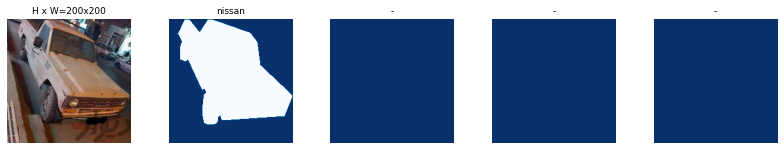

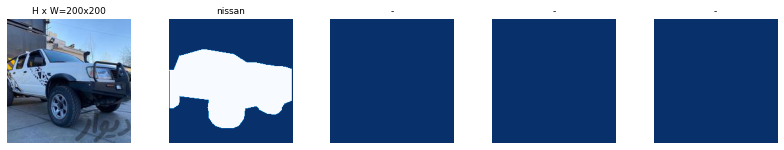

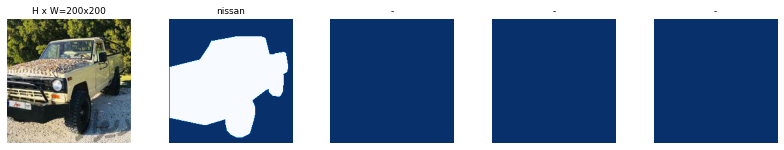

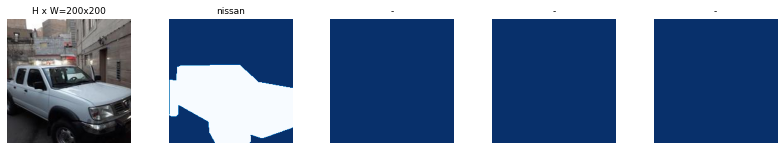

In [20]:
# Load and display random samples
image_ids = np.random.choice(train_set.image_ids, 4)
for image_id in image_ids:
    image = train_set.load_image(image_id)
    mask, class_ids = train_set.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_set.class_names)

## Bounding Boxes
Create bounding boxes on the images.

image_id  19 /content/drive/MyDrive/Colab Notebooks/Data/Car_test//train/nissan (346).jpg
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (200, 200, 1)         min:    0.00000  max:    1.00000  uint8
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (1, 4)                min:    0.00000  max:  198.00000  int32


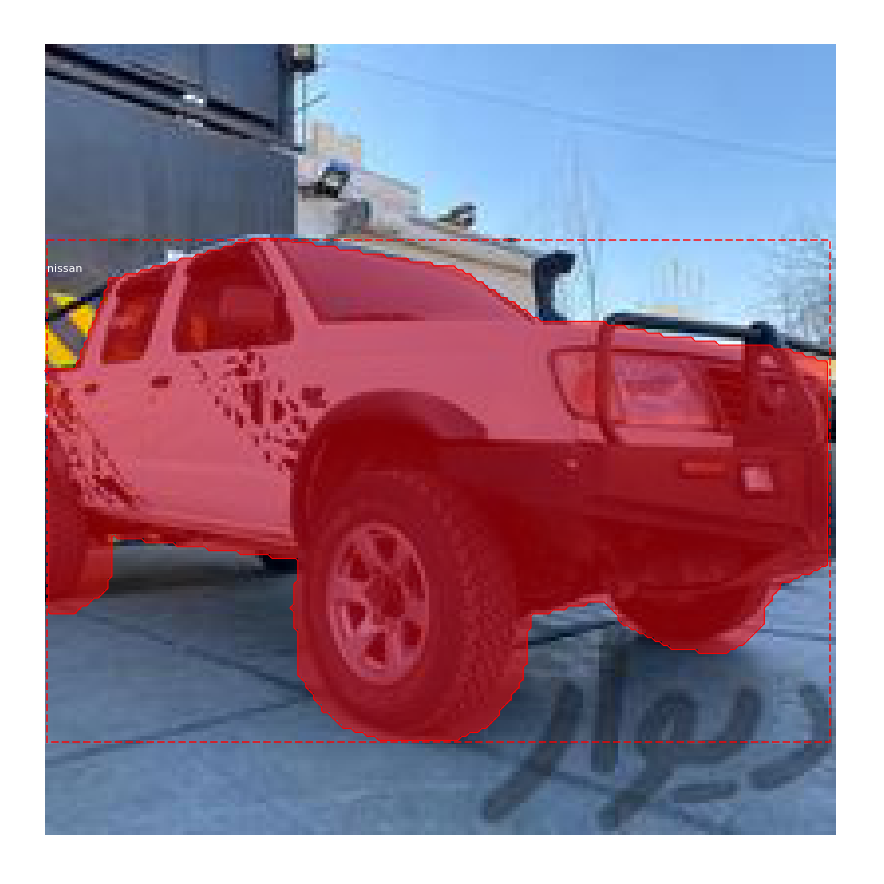

In [21]:
# Load random image and mask.
image_id = random.choice(train_set.image_ids)
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, train_set.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, train_set.class_names)

# Prepare Prediction Model
We use the inference model to make predicitons

In [22]:
class PredictionConfig(Config):
    NAME = "MaskRCNN_cfg"
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

## Load Saved Models from Google Drive:
***Note: Models not available on github.  
I will provide links in the notebook soon. 
Place model files in ./model_data/**

In [23]:
time_str='20210403'
weights_fname =modeldir+'saved/weights_Nissan_'+time_str+'.h5'
history_fname =modeldir+'saved/history_Nissan_'+time_str+'.json'

with open(history_fname, 'r') as file:
    history=file.read()
# parse file
hist_dict = json.loads(history)


## Load the Inference Model:

In [24]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights(weights_fname, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


# Training Evaluation
Let's first have a look at how the model performed during training using the history data.

In [25]:
def plot_training(metric):
    fig=plt.figure()
    plt.plot(hist_dict[metric], c='blue')
    plt.plot(hist_dict['val_'+metric], c='red')
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show()

These are the metrics available in the training history:

In [26]:
hist_dict=eval(hist_dict)
for metric in hist_dict:
    print(metric)

val_loss
val_rpn_class_loss
val_rpn_bbox_loss
val_mrcnn_class_loss
val_mrcnn_bbox_loss
val_mrcnn_mask_loss
loss
rpn_class_loss
rpn_bbox_loss
mrcnn_class_loss
mrcnn_bbox_loss
mrcnn_mask_loss


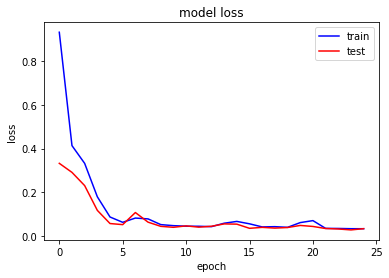

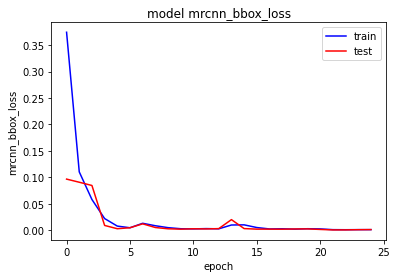

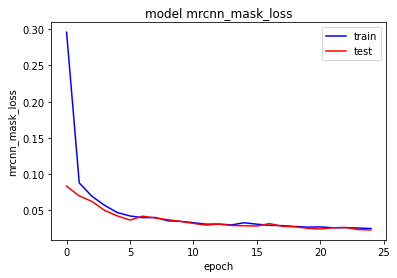

In [27]:
plot_training('loss')
plot_training('mrcnn_bbox_loss')
plot_training('mrcnn_mask_loss')


The model error on the training data is a short distance from the test.
Model error for predicting limit boxes and masks quickly converges with good values.
The training and test error for the limiting box is about 0.01 which is very good.
The error of training and testing for masks is also about 0.1, which is a good thing in predicting our masks.

## Evaluate the Model:
***May be slow to run on a local machine**

First we will look at the mean absolute precision (mAP). This is calculated by dividing the overlapping area of the predicted and actual bounding boxes by the total area of both boxes.   

In [28]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    # convert pixel values (e.g. center)
    scaled_image = mold_image(image, cfg)
    # convert image into one sample
    sample = np.expand_dims(scaled_image, 0)
    # make prediction
    yhat = model.detect(sample, verbose=0)
    # extract results for first sample
    r = yhat[0]
    # calculate statistics, including AP
    AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
    # store
    APs.append(AP)
  # calculate the mean AP across all images
  mAP = np.mean(APs)
  return mAP

In [29]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)


Train mAP: 1.000
Test mAP: 1.000


|Set|mAP Score|
|:---:|:---:|
|Train|67.7%|
|Test|57.7%|

We achieved 67.7% for the training set and 57.7% for the test set. These are good values so we can be confident the model should predict well. 

## Plot Actual vs. Predicted:
***May be slow to run on a local machine**

Now we can look at how the model perfomed on some of the annotated test set predictions

In [30]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    for i in range(n_images):
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        scaled_image = mold_image(image, cfg)
        sample = np.expand_dims(scaled_image, 0)

        yhat = model.detect(sample, verbose=0)[0]

        plt.subplot(n_images, 2, i*2+1)

        plt.imshow(image)
        plt.title('Actual')
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        plt.subplot(n_images, 2, i*2+2)
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            ax.add_patch(rect)
    plt.show()

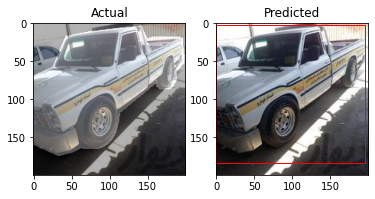

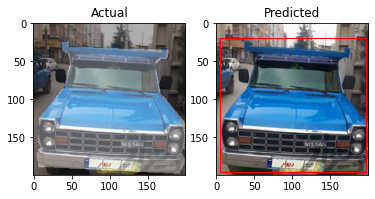

In [31]:
plot_actual_vs_predicted(train_set, model, cfg, n_images=1)
plot_actual_vs_predicted(test_set, model, cfg, n_images=1)

The model works well on the first image. The second image is a bit difficult due to shapes, textures and colors, and one of the restrictive boxes is made more than the expected range. This may be improved by thresholding probabilities.

# New Image Predictions
Now to predict some new images. 

I've increased the probability threshold to 95% to try to avoid false predictions. This will likely under predict some images, but should give definite predicitons for the key parts of the image.

In [32]:
def prediction(file, model, confidence=0.95, color='red'):
    image = skimage.io.imread(file)
    results = model.detect([image], verbose=1)[0]

    fig=plt.figure(figsize=(12,10))
    plt.plot()

    plt.imshow(image)
    plt.title('Predicted')
    ax = plt.gca()
    # Define the boxes with probabilies to keep
    keep=np.where(results['scores'] > confidence)
    keep=keep[0]
    
    for box in keep:
        y1, x1, y2, x2 = results['rois'][box]
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color=color)
        ax.add_patch(rect)
        ax.text(x1, y1, 'nissan', fontsize=12, color=color)
        ax.axis('off')
    plt.show()

    return results

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


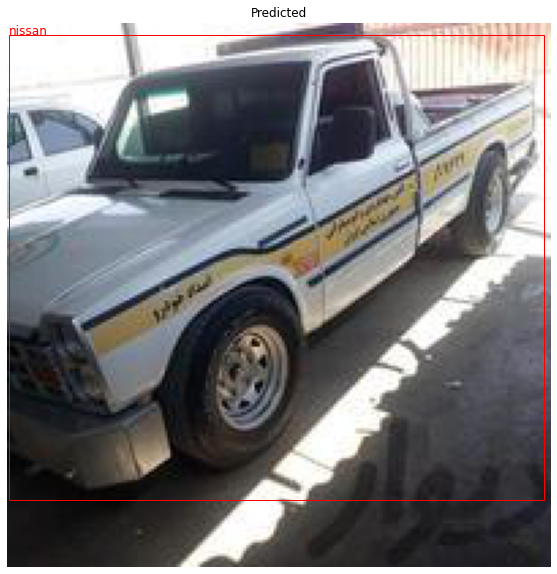

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


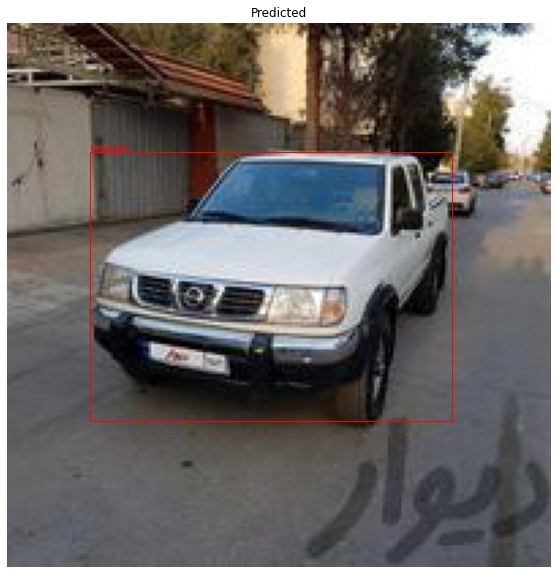

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


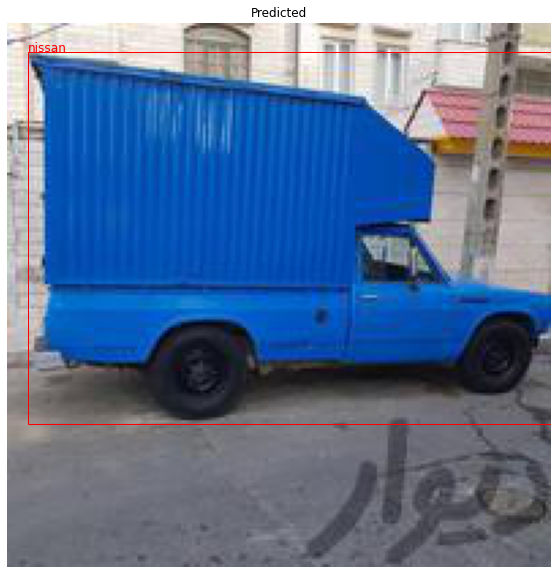

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


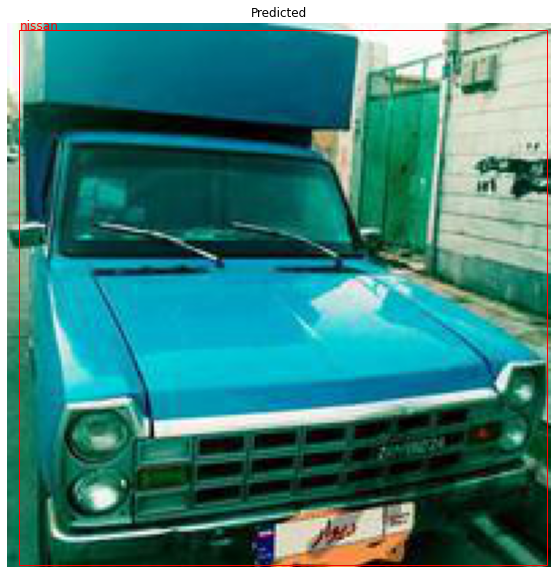

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


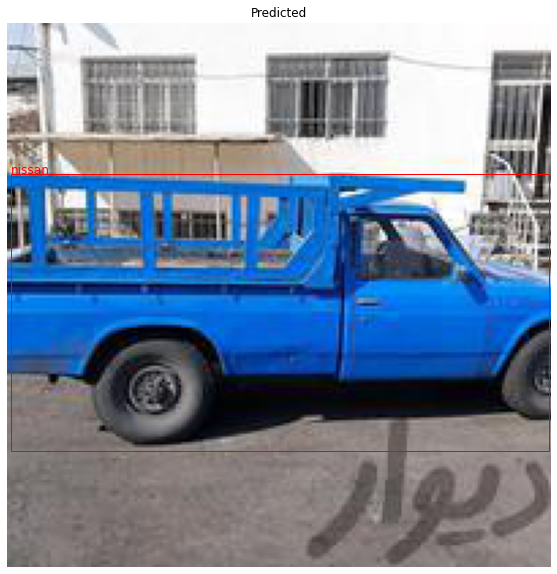

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


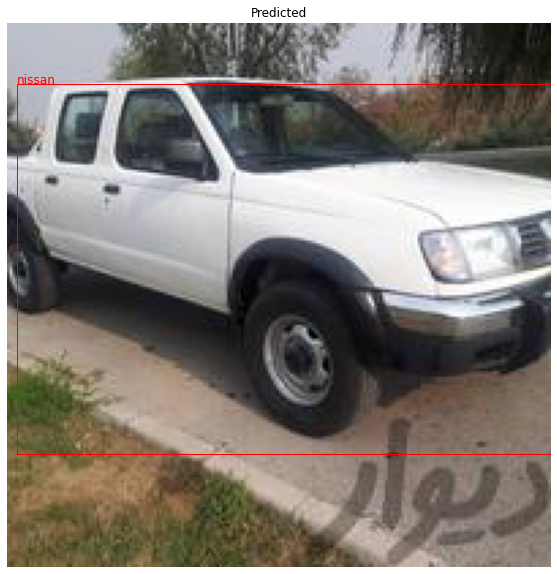

In [33]:
predictions=[]
filedir=datadir+'predict/'
for file in os.listdir(filedir):
    filepath=filedir+file
    predictions.append(prediction(filepath, model, 0.95));

The model does a good job at finding our cars, even in the final image which has a lot of cars!

Increasing the threshold means a lot of the background cars are missed in two of the photos. Reducing it down to 90% picks up more of the background cars in image 1, but also makes a false prediction on the apples. In the final image, even more of the cars are detected.  

## Image Segmentation
We can use the build-in mrcnn.visualize module to pull out the predicted masks with their probabilities and separate these from the image.

I'll update the notebook soon with a way to alter the thresholds.

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


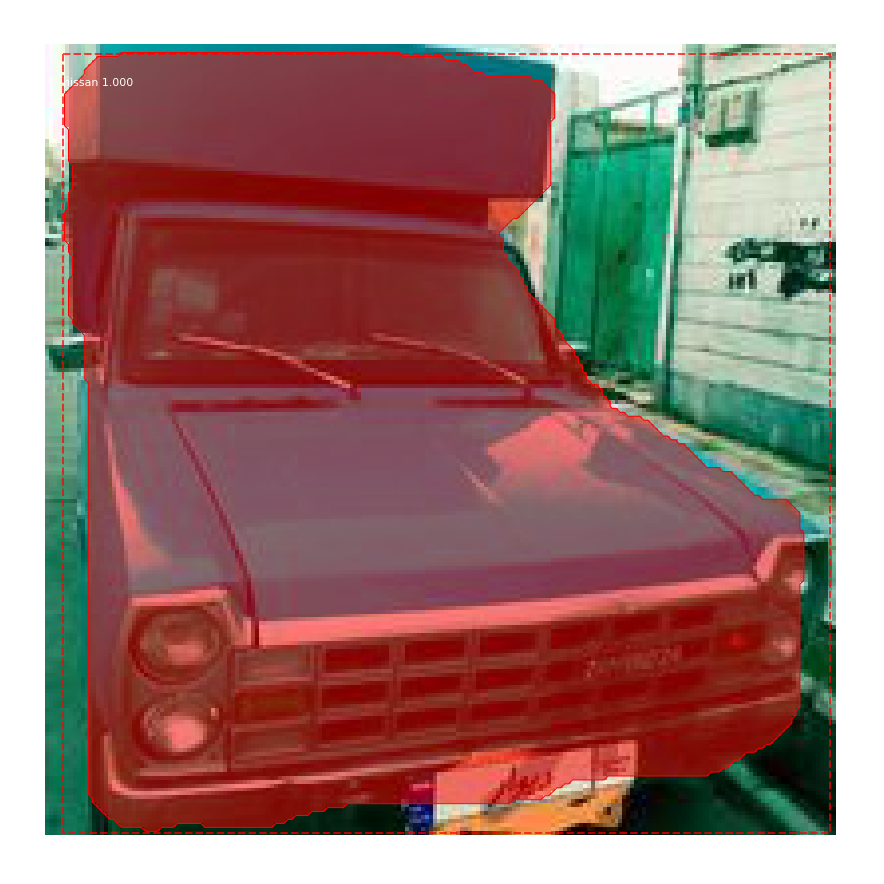

In [34]:
file=filedir+'/nissan (69).jpg'
image = skimage.io.imread(file)
class_names=train_set.class_names
p = model.detect([image], verbose=1)[0]
visualize.display_instances(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

Processing 1 images
image                    shape: (200, 200, 3)         min:    3.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


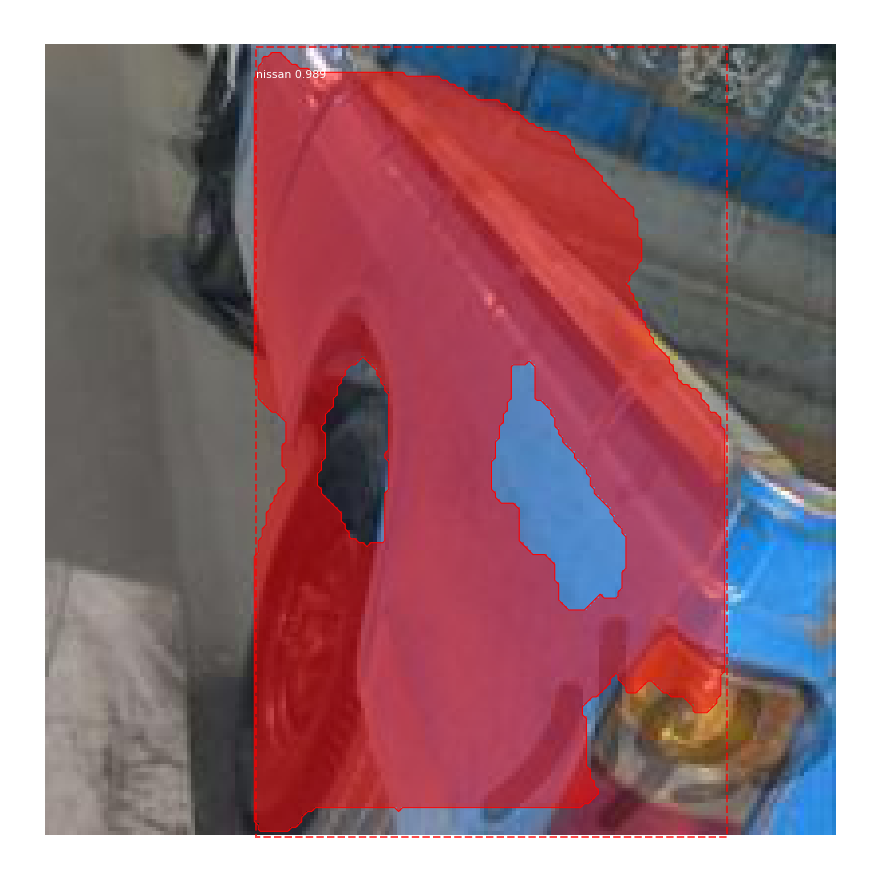

In [35]:
file=filedir+'/nissan (60).jpg'
image = skimage.io.imread(file)
class_names=train_set.class_names
p = model.detect([image], verbose=1)[0]
visualize.display_instances(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


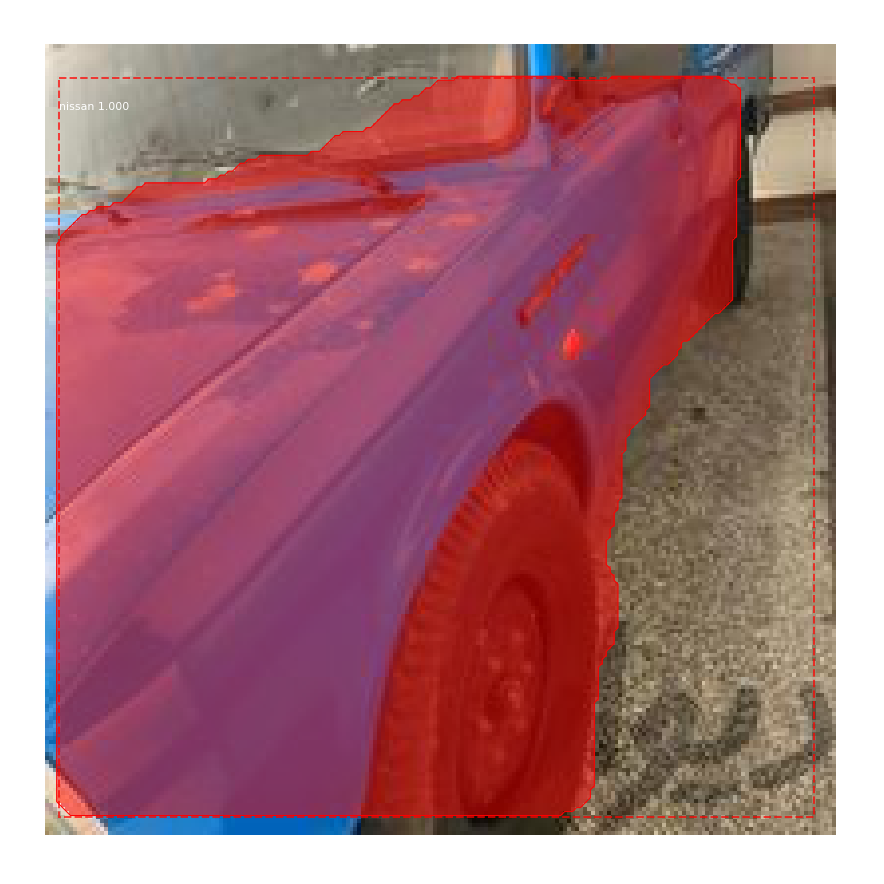

In [37]:
file=filedir+'/nissan (61).jpg'
image = skimage.io.imread(file)
class_names=train_set.class_names
p = model.detect([image], verbose=1)[0]
visualize.display_instances(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

Processing 1 images
image                    shape: (200, 200, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


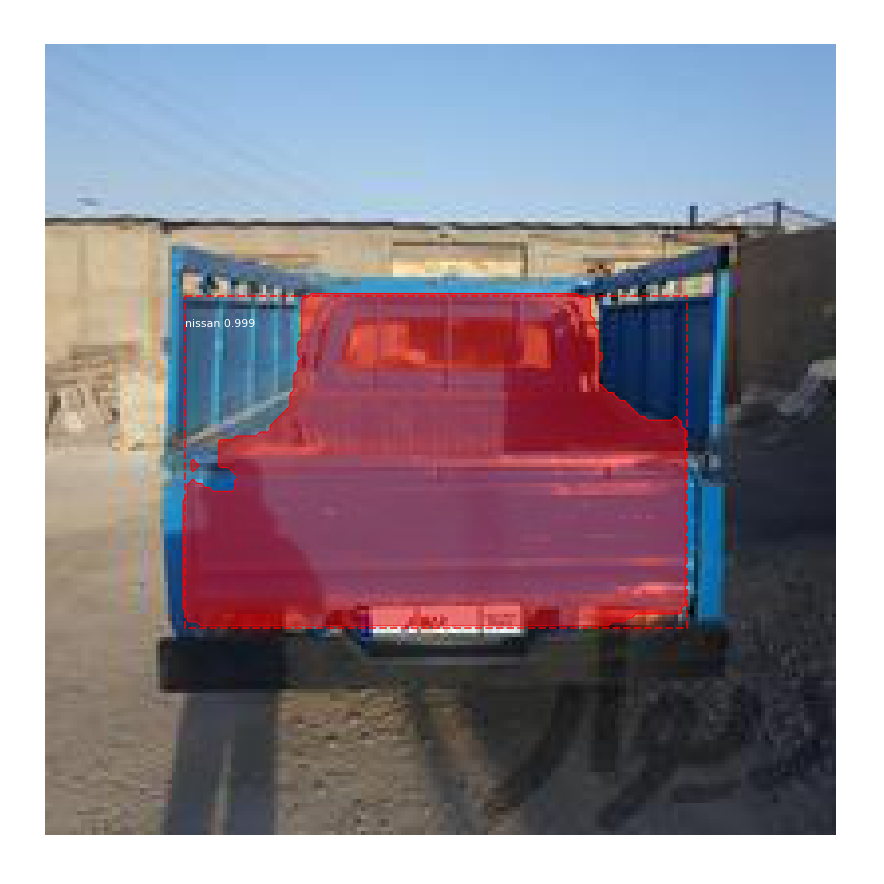

In [38]:
file=filedir+'/nissan (127).jpg'
image = skimage.io.imread(file)
class_names=train_set.class_names
p = model.detect([image], verbose=1)[0]
visualize.display_instances(image, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])

## Extract Segmentations
We can now loop through each mask and extract the bounding box area and the segmentation.

In [39]:
mask = p['masks']
mask = mask.astype(int)
mask.shape

#You can invert the masks using:
#mask = 1-mask

(200, 200, 1)

In [40]:
def segment(image, p, i):
    mask = p['masks'][:,:,i]
    bbox = p['rois'][i]
    mask = np.stack((mask,)*3, axis=-1)
    mask = mask.astype('uint8')
    bg = 255 - mask * 255
    mask_img = image*mask
    result = mask_img+ bg
    return result[bbox[0]:bbox[2], bbox[1]:bbox[3]]

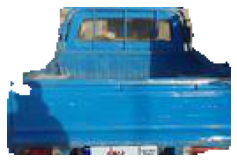

In [41]:
for i in range(mask.shape[2]):
    segmentation = segment(image, p, i)
    fig=plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.imshow(segmentation)


# Summary

Mask-RCNN is a state of the art object detection package and is fairly easy to use. Using transfer learning from the COCO dataset weights on the ResNet 101 model architecture.

Here we have annotated and trained a model on 22 images (20 train/2 test) and it has produced excellent results. 

The next step is to move to multiclass classification for the 3 types of car. 